# Demo Notebook 2: Fine-tuning Vision-Language Models with LoRA


## 1. Introduction to LoRA

### What is LoRA?

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning method that:

- Freezes the pre-trained model weights
- Injects trainable low-rank decomposition matrices into each layer
- Reduces trainable parameters by 10,000x while maintaining performance
- Enables fine-tuning on consumer GPUs

### Mathematical Foundation

For a pre-trained weight matrix $W_0 \in \mathbb{R}^{d \times k}$:

$$W = W_0 + \Delta W = W_0 + BA$$

Where:
- $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$
- $r \ll \min(d, k)$ (rank is much smaller)
- Only $B$ and $A$ are trained

### Why LoRA for VLMs?

| Aspect | Full Fine-tuning | LoRA |
|--------|-----------------|------|
| **Parameters** | Billions | Millions |
| **GPU Memory** | 80GB+ | 16GB |
| **Training Time** | Days | Hours |
| **Storage** | GBs per task | MBs per task |
| **Performance** | 100% | 95-99% |

---

## 2. Setup and Installation

### Install Required Libraries

In [1]:
!pip install -q -U trl bitsandbytes peft datasets tensorboard
!pip install -q transformers accelerate pillow requests matplotlib
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.


### Import Dependencies

In [2]:
import torch
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
os.environ["WANDB_DISABLED"] = "true"

# Transformers and PEFT
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from peft import LoraConfig

# Datasets
from datasets import load_dataset

# TRL for SFTTrainer
from trl import SFTTrainer, SFTConfig

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB


---

## 3. Dataset Preparation


### Load Dataset

In [17]:
from collections import Counter
import random
# from sklearn.model_selection import train_test_split # Removed sklearn's train_test_split

# Load
dataset = load_dataset("lmms-lab/VQAv2", split="validation[:1%]")

# Helper to get most frequent answer
def get_best_answer(example):
    answers = [ans["answer"] for ans in example["answers"]]
    return Counter(answers).most_common(1)[0][0]

# Format as chat: user (image + question) → assistant (answer)
def format_chat(example):
    best_answer = get_best_answer(example)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["question"]}
            ]
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": best_answer}]
        }
    ]
    # Return messages and the original image column to keep it in the dataset
    return {"messages": messages, "image": example["image"]}

# Apply formatting
formatted_dataset = dataset.map(format_chat, remove_columns=dataset.column_names)

# Split for train/eval (80/20) using the datasets library's own train_test_split method
split_dataset = formatted_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")
print(f"Sample train data keys: {train_dataset[0].keys()}")

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/143 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/143 [00:00<?, ?it/s]

Map:   0%|          | 0/2144 [00:00<?, ? examples/s]

Training samples: 1715
Validation samples: 429
Sample train data keys: dict_keys(['image', 'messages'])


### Visualize Dataset Samples

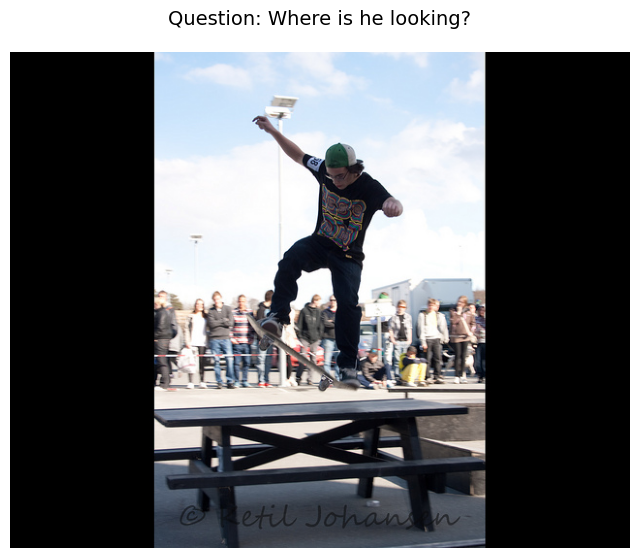

Question: Where is he looking?
Question ID: 262148000

Answers:
  • down
  • down
  • at table
  • skateboard
  • down
  • table
  • down
  • down
  • down
  • down


In [10]:
# Take the first example
sample = dataset[0]

# Display the image
image = sample["image"]  # This is already a PIL Image in lmms-lab/VQAv2
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(f"Question: {sample['question']}", fontsize=14, pad=20)
plt.show()

# Print question and all answers with their counts
print(f"Question: {sample['question']}")
print(f"Question ID: {sample['question_id']}")
print("\nAnswers:")
for answer in sample["answers"]:
    print(f"  • {answer['answer']}")

---

## 4. Model Preparation

### Load Model and Processor

In [11]:
model_id = "google/gemma-3-4b-it"  # Smallest multimodal variant

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_storage=torch.bfloat16,
)

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.bfloat16,
    attn_implementation="eager",
    quantization_config=bnb_config
)

processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

### Configure LoRA

In [25]:
# LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"],
    ensure_weight_tying=True,
)

### Understanding LoRA Parameters

| Parameter | Description | Typical Values |
|-----------|-------------|----------------|
| **r** | Rank of adaptation matrices | 8, 16, 32, 64 |
| **lora_alpha** | Scaling factor (typically 2×r) | 16, 32, 64 |
| **target_modules** | Which layers to adapt | q_proj, v_proj, k_proj |
| **lora_dropout** | Regularization | 0.05, 0.1 |

**Trade-offs:**
- Higher `r` → More capacity but more parameters
- More `target_modules` → Better performance but slower training

---

## 5. Training Setup
### Define Collate Function

In [18]:
def collate_fn(examples):
    texts = []
    images = []

    for ex in examples:
        # Apply chat template to full conversation (includes assistant for SFT)
        text = processor.apply_chat_template(
            ex["messages"],
            tokenize=False,
            add_generation_prompt=False,  # No extra prompt for training
        ).strip()
        texts.append(text)
        images.append(ex["image"].convert("RGB"))

    # Processor tokenizes + embeds images
    batch = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,  # Tune based on your VRAM; Gemma supports 128K
    )

    # Labels: Clone input_ids, mask pads (image embeddings auto-ignored in loss)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    batch["labels"] = labels
    return batch

### Configure Training Arguments

In [26]:
training_args = SFTConfig(
    output_dir="gemma-3-4b-vqa-finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    save_strategy="epoch",
    learning_rate=2e-05,
    bf16=True,
    report_to="none",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,
    logging_steps=10,  # For monitoring
)

### Set Up SFTTrainer

In [27]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor,
)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


---

## 6. Train the Model

In [28]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss
10,20.343500
20,13.538900
30,10.270400
40,8.326000
50,5.544900
60,2.439600
70,1.001500
80,0.623200
90,0.392900
100,0.229900


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=429, training_loss=1.5204372799202002, metrics={'train_runtime': 3202.0562, 'train_samples_per_second': 0.536, 'train_steps_per_second': 0.134, 'total_flos': 1.2422017763510784e+16, 'train_loss': 1.5204372799202002, 'entropy': 0.07222644676055227, 'num_tokens': 477712.0, 'mean_token_accuracy': 0.9805271182741437, 'epoch': 1.0})